#  The Facial Expression Recognition Challenge data in Kaggle
* Using Convolutional Neural Network (CNN) to categorize emotions 

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

## load data
def getData(balance_ones = True):
    # images are 48x48 = 2304 size vectors
    Y = []
    X = []
    first = True
    for line in open('fer2013.csv'): # emotion,pixels,Usage
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))  
            X.append([int(p) for p in row[1].split()])  
    # normalize X    
    X, Y = np.array(X) / 255.0, np.array(Y)
    if balance_ones:
        # balance the first class (547 samples)
        X0, Y0 = X[Y!=1, :], Y[Y!=1]
        X1 = X[Y==1, :]
        X1 = np.repeat(X1, 9, axis=0) 
        X = np.vstack([X0, X1]) 
        Y = np.concatenate( ( Y0, [1]*len(X1) ) )
    return X, Y

def getImageData():
    X, Y = getData()
    N, D = X.shape
    d = int(np.sqrt(D))
    X = X.reshape(N, 1, d, d) # [N, C, H, W]
    return X, Y

## Showing one image for each emotion randomly

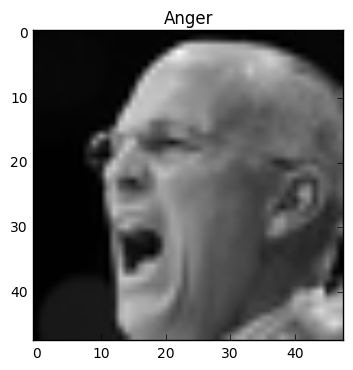

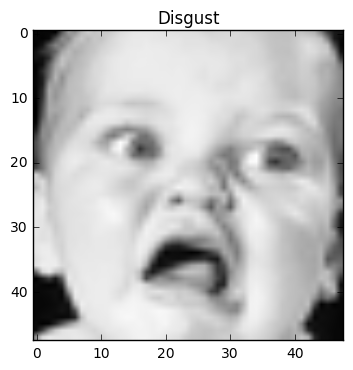

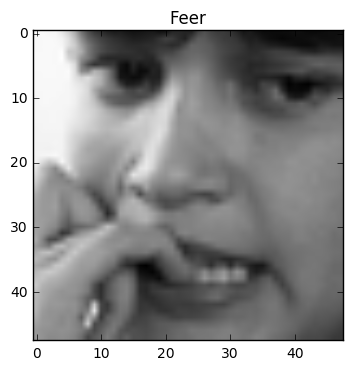

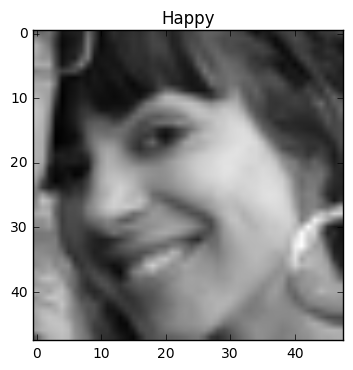

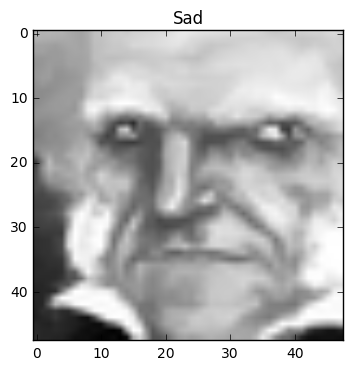

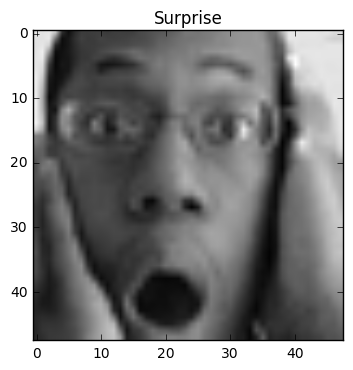

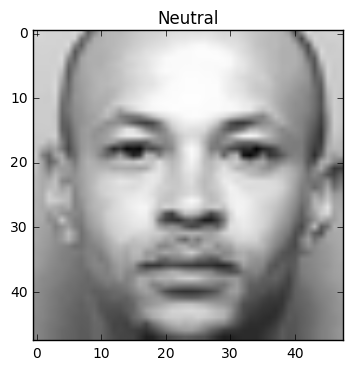

In [2]:
label_map = [ 'Anger','Disgust','Feer','Happy','Sad','Surprise','Neutral' ]
def main():
    X, Y = getData(balance_ones = False) # emotion, pixels
    for i in range(7):
        x, y = X[Y==i], Y[Y==i] # images for i(th) emotion
        N = len(y) 
        j = np.random.choice(N) 
        plt.imshow(x[j].reshape(48, 48), cmap='gray')  
        plt.title(label_map[y[j]])
        plt.show()
main()

* Defining functions

In [3]:
## target matrix
def y2indicator(y): 
    N = len(y)
    K = len(set(y))
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

## initial weight and bias for ANN
def init_weight_and_bias(M1, M2):
    W = np.random.randn(M1, M2) / np.sqrt(M1 + M2)
    b = np.zeros(M2)
    return W.astype(np.float32), b.astype(np.float32)

## initial weight and bias for CNN
def init_filter(shape, poolsz):
    w = np.random.randn(*shape) / np.sqrt(np.prod(shape[:-1]) + shape[-1]*np.prod(shape[:-2] / np.prod(poolsz)))
    return w.astype(np.float32)

* Defining the hidden layer class for Artificial Neural Network (ANN)

In [4]:
class HiddenLayer(object):
    def __init__(self, M1, M2, an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W, b = init_weight_and_bias(M1, M2)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))
        self.params = [self.W, self.b]

    def forward(self, X):
        return tf.nn.relu(tf.matmul(X, self.W) + self.b)

* Defining the calss of convolutional layers and max-pooling layers for ANN

In [5]:
class ConvPoolLayer(object):
    def __init__(self, mi, mo, fw=5, fh=5, poolsz=(2, 2)):
        sz = (fw, fh, mi, mo) # [W, H, C, N]
        W0 = init_filter(sz, poolsz)
        self.W = tf.Variable(W0)
        b0 = np.zeros(mo, dtype=np.float32)
        self.b = tf.Variable(b0)
        self.poolsz = poolsz
        self.params = [self.W, self.b]

    def forward(self, X):
        conv_out = tf.nn.conv2d(X, self.W, strides=[1, 1, 1, 1], padding = 'SAME') # [N, H, W, C]
        conv_out = tf.nn.bias_add(conv_out, self.b)
        pool_out = tf.nn.max_pool(conv_out, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
        return tf.tanh(pool_out)

* Using Mini-batch gradient descent with batch size = 30 and RMSProp Optimizer with the momentum parameter and decay rate  
* Defining the class for CNN

In [6]:
class CNN(object):
    def __init__(self, convpool_layer_sizes, hidden_layer_sizes):
        self.convpool_layer_sizes = convpool_layer_sizes
        self.hidden_layer_sizes = hidden_layer_sizes

    def fit(self, X, Y, lr = 10e-4, mu = 0.99, reg = 10e-4, decay = 0.99999, 
            eps = 10e-3, batch_sz = 30, epochs = 4, show_fig = True):
        lr = np.float32(lr)
        mu = np.float32(mu)
        reg = np.float32(reg)
        decay = np.float32(decay)
        eps = np.float32(eps)
        K = len(set(Y))
        print_period = 300
         
        # make a validation set
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = y2indicator(Y).astype(np.float32)

        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]
        Yvalid_flat = np.argmax(Yvalid, axis=1)  

        # initialize convolutional layers and max-pooling layers
        N, d, d, c = X.shape # [N, H, W ,C]
        mi = c
        outw = d
        outh = d
        self.convpool_layers = []
        for mo, fw, fh in self.convpool_layer_sizes:
            layer = ConvPoolLayer(mi, mo, fw, fh) # [W, H, C, N]
            self.convpool_layers.append(layer)
            outw = outw / 2
            outh = outh / 2
            mi = mo

        # initialize hidden layers
        self.hidden_layers = []
        M1 = self.convpool_layer_sizes[-1][0]*outw*outh # size must be same as output of last convpool layer
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayer(M1, M2, count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1

        # logistic regression layer
        W, b = init_weight_and_bias(M1, K)  
        self.W = tf.Variable(W, 'W_logreg')
        self.b = tf.Variable(b, 'b_logreg')

        self.params = [self.W, self.b]
        for h in self.convpool_layers:
            self.params += h.params
        for h in self.hidden_layers:
            self.params += h.params

        # set up tensorflow functions and variables
        tfX = tf.placeholder(tf.float32, shape=(None, d, d, c), name='X')
        tfY = tf.placeholder(tf.float32, shape=(None, K), name='Y')
        act = self.forward(tfX)

        rcost = reg*sum([tf.nn.l2_loss(p) for p in self.params])
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(act, tfY)) + rcost
        prediction = self.predict(tfX)

        train_op = tf.train.RMSPropOptimizer(lr, decay=decay, momentum=mu).minimize(cost)

        n_batches = int(N / batch_sz)
        costs = []
        accs = []
        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)
            for i in range(epochs):
                X, Y = shuffle(X, Y)
                for j in range(n_batches):
                    Xbatch = X[j*batch_sz:(j+1)*batch_sz]
                    Ybatch = Y[j*batch_sz:(j+1)*batch_sz]

                    session.run(train_op, feed_dict={tfX: Xbatch, tfY: Ybatch})

                    if j % print_period == 0 or j == (n_batches-1):
                        c = session.run(cost, feed_dict={tfX: Xvalid, tfY: Yvalid})
                        costs.append(c)

                        p = session.run(prediction, feed_dict={tfX: Xvalid, tfY: Yvalid})
                        acc = np.mean(Yvalid_flat == p)
                        accs.append(acc)
                        print('epoch:', i+1, 'batch:', j+1, 'cost:', c, 'accuaracy:', acc)
            print('')
            print('final accuracy: %.2f' % (accs[-1]*100), '%', sep='' )
            
        if show_fig:
            plt.plot(np.arange(1, len(costs)+1, 1), costs)
            plt.title('Cost')
            plt.show()
            plt.clf()
            plt.plot(np.arange(1, len(accs)+1, 1), accs)
            plt.title('Accuracy')
            plt.show()

    def forward(self, X): #
        Z = X
        for c in self.convpool_layers:
            Z = c.forward(Z)
        Z_shape = Z.get_shape().as_list()  
        Z = tf.reshape(Z, [-1, np.prod(Z_shape[1:])]) # [N, H, W, C]
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return tf.matmul(Z, self.W) + self.b

    def predict(self, X):
        pY = self.forward(X)
        return tf.argmax(pY, 1)

* CNN for the Facial Expression Recognition data

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


epoch: 1 batch: 1 cost: 2.27291 accuaracy: 0.123
epoch: 1 batch: 301 cost: 2.1775 accuaracy: 0.263
epoch: 1 batch: 601 cost: 1.95735 accuaracy: 0.4
epoch: 1 batch: 901 cost: 1.89291 accuaracy: 0.409
epoch: 1 batch: 1201 cost: 1.78388 accuaracy: 0.443
epoch: 1 batch: 1308 cost: 1.74608 accuaracy: 0.438
epoch: 2 batch: 1 cost: 1.74701 accuaracy: 0.441
epoch: 2 batch: 301 cost: 1.65253 accuaracy: 0.468
epoch: 2 batch: 601 cost: 1.54558 accuaracy: 0.521
epoch: 2 batch: 901 cost: 1.50917 accuaracy: 0.533
epoch: 2 batch: 1201 cost: 1.50032 accuaracy: 0.516
epoch: 2 batch: 1308 cost: 1.46554 accuaracy: 0.528
epoch: 3 batch: 1 cost: 1.46563 accuaracy: 0.527
epoch: 3 batch: 301 cost: 1.44245 accuaracy: 0.539
epoch: 3 batch: 601 cost: 1.43812 accuaracy: 0.568
epoch: 3 batch: 901 cost: 1.41964 accuaracy: 0.557
epoch: 3 batch: 1201 cost: 1.40385 accuaracy: 0.555
epoch: 3 batch: 1308 cost: 1.40243 accuaracy: 0.563
epoch: 4 batch: 1 cost: 1.4024 accuaracy: 0.566
epoch: 4 batch: 301 cost: 1.43451 acc

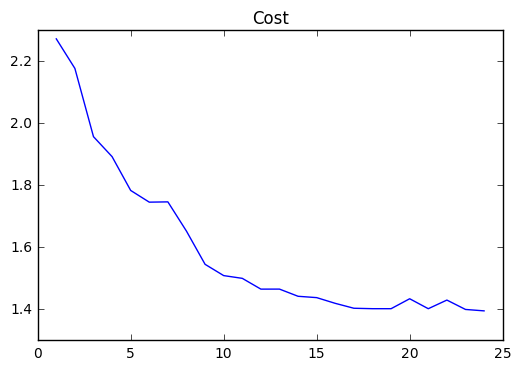

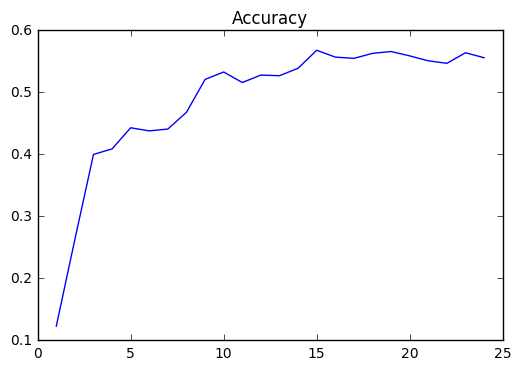

In [7]:
X, Y = getImageData()
X = X.transpose((0, 2, 3, 1)) # [N, C, H, W] -> [N, H, W, C]

model = CNN(convpool_layer_sizes=[(20, 5, 5), (20, 5, 5)], hidden_layer_sizes=[500, 300])
model.fit(X, Y, epochs = 4) 

* Final accuracy of CNN is 55.6%
* The categorization accuracies of the Facial Expression Recognition Challenge range from 31.04% to 71.16%